In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.patches as patches

from config import Config
import utils
import model as modellib
import visualize
from model import log

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline                                                                                                                                


# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "data/image")

/home/nghia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import ocr
    
config = ocr.OcrConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        180
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           ocr
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING       

In [3]:
# Training dataset
dataset_train = ocr.OcrDataset()
dataset_train.load_ocr(np.load('ocr-train-cv.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = ocr.OcrDataset()
dataset_val.load_ocr(np.load('ocr-val.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [4]:
# class InferenceConfig(ocr.Config()):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()
config.GPU_COUNT =1
config.IMAGES_PER_GPU =1
config.BATCH_SIZE = 1
    
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/nghia/work/Mask_RCNN/logs/ocr20180406T1009/mask_rcnn_ocr_0010.h5


In [5]:
# import the necessary packages
import numpy as np
import cv2

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
#     print("four_point_transform rect", rect)

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [6]:
from skimage.feature import corner_harris, corner_peaks
import matplotlib.patches

def predict_mask(original_image, mask, box):
    y1, x1, y2, x2 = box

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    verts1 = corner_peaks(corner_harris(padded_mask), min_distance=1)
    verts1 = np.fliplr(verts1) - 1
    crop_img = original_image.copy()
    
    crop_img = crop_img[y1-5:y2+5,x1-1:x2+1,:]
    image = original_image.copy()
    pts = np.array(verts1, dtype = "float32")
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    rect[0] = [tl[0]-1, tl[1]-8]
    rect[1] = [tr[0]+1, tr[1]-8]
    rect[2] = [br[0]+1, br[1]+8]
    rect[3] = [bl[0]-1, bl[1]+8]

    # apply the four point tranform to obtain a "birds eye view" of
    # the image
    warped = four_point_transform(image, rect)
    return crop_img, warped

In [58]:
import skimage
class_names = ['BG', 'box']
def predict_and_extract1(image_path, i=0, j=i+1, save_dir=""):
    image = skimage.io.imread(image_path)
    results = model.detect([image], verbose=1)

    r = results[0]
    print(r['masks'].shape)
    print(r['rois'].shape)
    print(r['class_ids'].shape)
    print(r['masks'][:,:,i:j].shape)
    visualize.display_instances(image, r['rois'][i:j,:], r['masks'][:,:,i:j], r['class_ids'][i:j], 
                            class_names, r['scores'][i:j])
    return image, r


Processing 1 images
image                    shape: (4032, 3024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 4032.00000
(4032, 3024, 47)
(47, 4)
(47,)
(4032, 3024, 47)


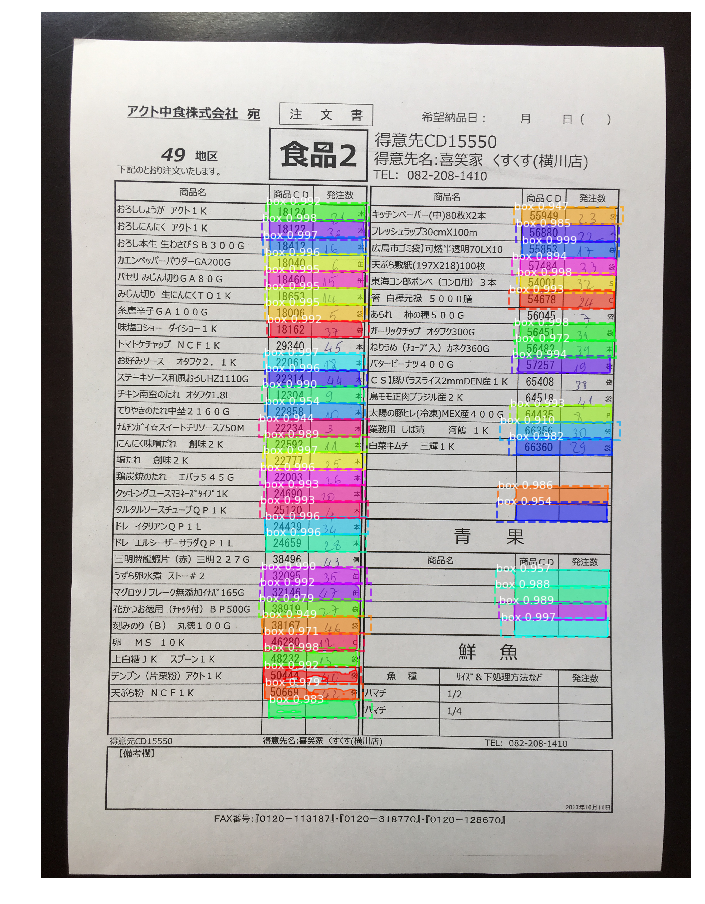

In [61]:
i = 10
image_id = 3
image, r = predict_and_extract1("dataset_csv/IMG_7928.JPG", i=0,j=47)

In [ ]:
# i = 10
# j = i+10
# crops, wraps = extract_pred(image_id, image, r['masks'][:,:,i:j], r['rois'][i:j,:],  r['class_ids'][i:j], class_pred=1, save_dir="")
# print("crops", np.array(crops).shape, "wraps", np.array(wraps).shape)

In [10]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 3))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [11]:
# image is expected be in RGB color space
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([200, 200,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

# show_images(list(map(select_rgb_white_yellow, wraps)))

In [12]:
def split_image(image, percent=0.45):
    rows, cols = image.shape[:2]
    left = image.copy()
    left = left[:,0:int(cols*percent)]
    # plt.imshow(left,cmap=None)
    # plt.show()
    right = image.copy()
    right = right[:,int(cols*percent):cols]
    # plt.imshow(right,cmap=None)
    # plt.show()
    return left, right

In [13]:
import handwriting
    
configh = handwriting.HandwritingConfig()
# configh.display()
h, w = configh.IMAGE_SHAPE[:2]
class InferenceConfig(handwriting.HandwritingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_configh = InferenceConfig()

# Recreate the model in inference mode
modelh = modellib.MaskRCNN(mode="inference", 
                          config=inference_configh,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
modelh_path = modelh.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert modelh_path != "", "Provide path to trained weights"
print("Loading weights from ", modelh_path)
modelh.load_weights(modelh_path, by_name=True)

Loading weights from  /home/nghia/work/Mask_RCNN/logs/handwriting20180412T1100/mask_rcnn_handwriting_0010.h5


In [142]:
def get_predict_order(boxes):
    N = boxes.shape[0]
    middles = []
    for i in range(N):
        y1, x1, y2, x2 = boxes[i]
        middle_x = (x2-x1)/2 + x1
        middles.append((i, middle_x))
        
    dtype = [('index', int), ('middle', float)]
    a = np.array(middles, dtype=dtype)
    print(a)
    a = np.sort(a, order='middle')
    print(a)
    return a
def predict_value(orders, class_ids):
    predict = []
    for i in range(orders.shape[0]):
        idx, _ = orders[i]
        class_id = class_ids[idx]
        if class_id == 10:
            class_id = 0
        predict.append(class_id)
    return predict

In [22]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# show_images(list(map(convert_hls, wraps)))

In [23]:
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)


In [24]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([180, 180, 180])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([200, 200,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

In [105]:
import pytesseract
import visualize
import re
class_names = ['BG', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

def predict_all(images):
    presults = []
    for image in images:
        left, right = split_image(image, percent=0.46)
        left = cv2.resize(left, (128, 64))
        right = cv2.resize(right, (128, 64))
        resized_left = select_rgb_white_yellow(left)
        resized_right = select_rgb_white_yellow(right)
        show_images([left, right, resized_left, resized_right])
        print("--predict left tesseract--")
        text_left = pytesseract.image_to_string(left, lang='eng', boxes=False, config='--psm 10 --eom 3 -c tessedit_char_whitelist=0123456789')
        print(text_left)
        lefts = [int(s) for s in re.findall(r'\b\d+\b', text_left)]
        print("--predict right tesseract--")
        text = pytesseract.image_to_string(right, lang='eng', boxes=False, config='--psm 10 --eom 3 -c tessedit_char_whitelist=0123456789')
        print(text)
        
        print("--predict left--")
        results = modelh.detect([resized_left], verbose=0)

        r = results[0]
        orders = get_predict_order(r['rois'])
        left_predicts = predict_value(orders, r['class_ids'])
        print(left_predicts)
        
        print("--predict right--")
        results = modelh.detect([resized_right], verbose=0)
        r = results[0]
        orders = get_predict_order(r['rois'])
        right_predicts = predict_value(orders, r['class_ids'])
        print(right_predicts)
        presults.append(("".join(map(str, lefts)),"".join(map(str,left_predicts)),"".join(map(str,right_predicts))))
    
    return presults
    

In [26]:
def extract_pred(image_id, original_image, masks, boxes, classes, class_pred=2, save_dir=''):
    crops = []
    wraps = []
    for i in range(masks.shape[2]):
#         print(i)
        mask = masks[:, :, i]
        box = boxes[i]
        class_id = classes[i]
        if class_id == class_pred:
            crop_img, warped = predict_mask(original_image, mask, box)
            crops.append(crop_img)
            wraps.append(warped)
            if False:
                p_crop = os.path.join(save_dir, "%03d_%03d_crop.jpg" % (image_id, i))
                p_wrap = os.path.join(save_dir, "%03d_%03d_wrap.jpg" % (image_id, i))
#                 print(p_crop)
#                 print(p_wrap)
                cv2.imwrite(p_crop, crop_img)
                cv2.imwrite(p_wrap, warped)
            if False:
                print("crop")
                plt.figure(figsize=(12, 12))
                plt.imshow(crop_img)
                plt.show()
                print("wraped")
                plt.figure(figsize=(12, 12))
                plt.imshow(warped)
                plt.show()
    
    return crops, wraps

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -114.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(1024, 1024, 53)
(53, 4)
(53,)
(1024, 1024, 1)


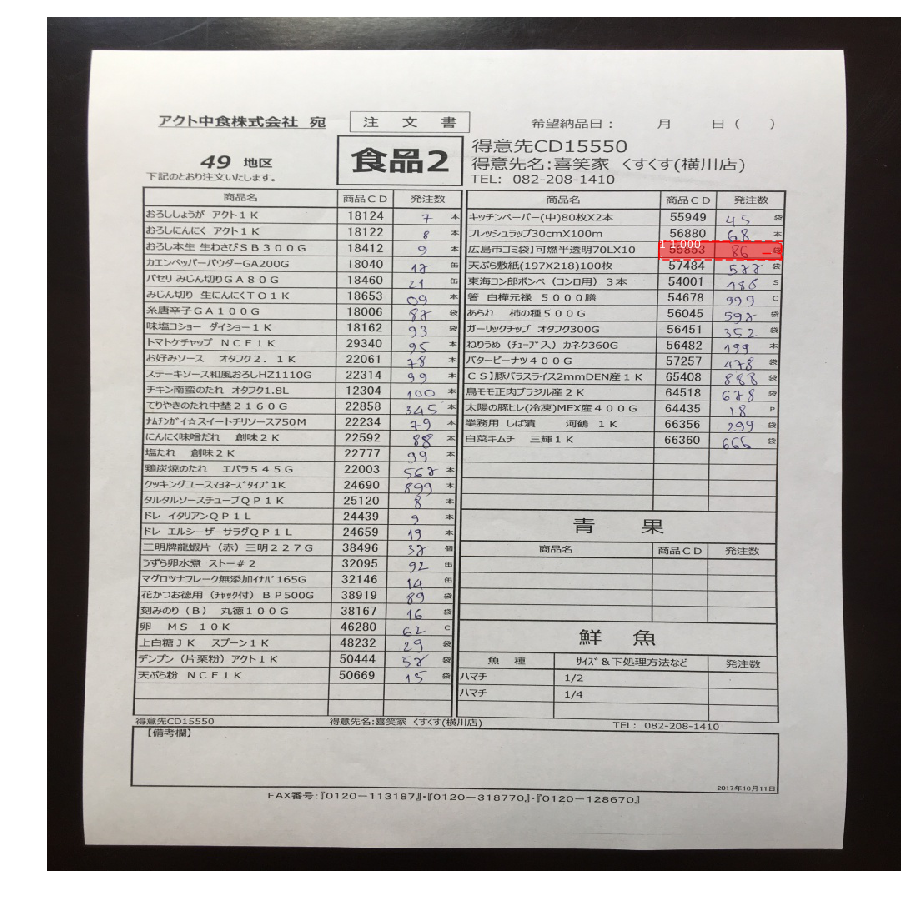

In [156]:
i = 1
image_id = 3
image, r = predict_and_extract1("data/dataset_resized_ver2/imageresized_40.jpg", i=0,j=1)

In [157]:
# image_id = 3
# image, r = predict_and_extract1("data/image/imageresized_66.jpg", i=0)

i = 0
j = r['rois'].shape[0]
crops, wraps = extract_pred(image_id, image, r['masks'][:,:,i:j], r['rois'][i:j,:],  r['class_ids'][i:j], class_pred=1, save_dir="")
print("crops", np.array(crops).shape, "wraps", np.array(wraps).shape)
# white_yellow_images = list(map(select_rgb_white_yellow, wraps))
# white_yellow_images_crops = list(map(select_rgb_white_yellow, crops))

crops (53,) wraps (53,)


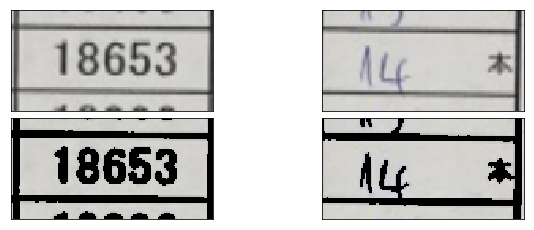

[(0, 28.5) (1, 45. )]
[(0, 28.5) (1, 45. )]
[(0, 28.5) (1, 45. )]
[1 4]
[1, 4]


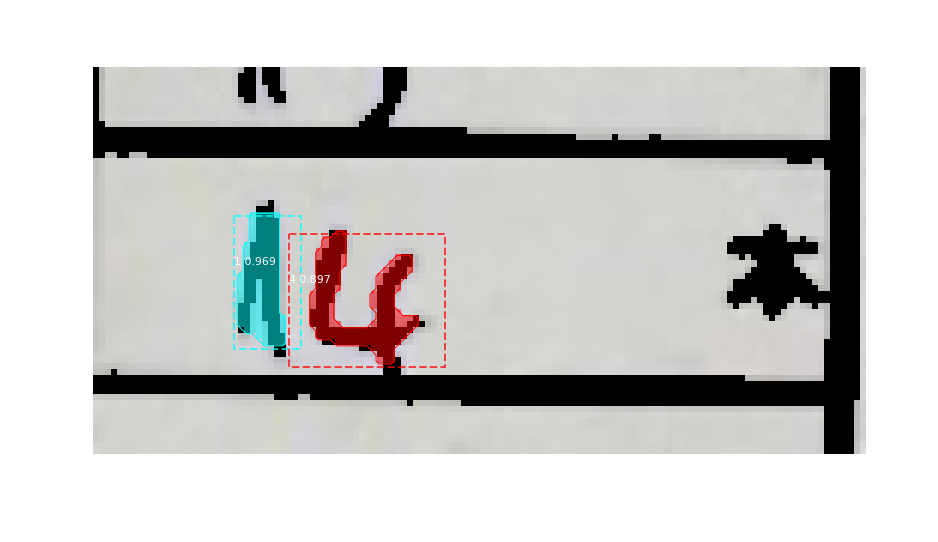

In [145]:
digit_names = ['BG', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
image = crops[7]
left, right = split_image(image, percent=0.46)
left = cv2.resize(left, (128, 64))
right = cv2.resize(right, (128, 64))
resized_left = select_rgb_white_yellow(left)
resized_right = select_rgb_white_yellow(right)
show_images([left, right, resized_left, resized_right])
results = modelh.detect([resized_right], verbose=0)
r = results[0]
orders = get_predict_order(r['rois'])
print(orders)
print(r['class_ids'])
right_predicts = predict_value(orders, r['class_ids'])
visualize.display_instances(resized_right, r['rois'][i:j,:], r['masks'][:,:,i:j], r['class_ids'][i:j], 
                            digit_names, r['scores'][i:j])
print(right_predicts)

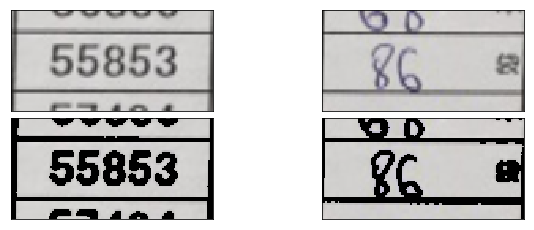

--predict left tesseract--
oe
--predict right tesseract--
a
--predict left--
[(0, 81.5) (1, 40.5) (2, 97.5) (3, 86.5) (4, 65.5) (5, 48.5)]
[(1, 40.5) (5, 48.5) (4, 65.5) (0, 81.5) (3, 86.5) (2, 97.5)]
[2, 5, 2, 5, 2, 3]
--predict right--
[(0, 55.5) (1, 38. )]
[(1, 38. ) (0, 55.5)]
[8, 2]


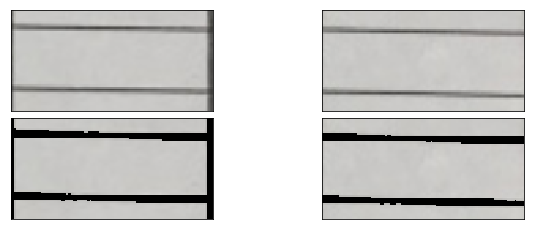

--predict left tesseract--
es
--predict right tesseract--
eee
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


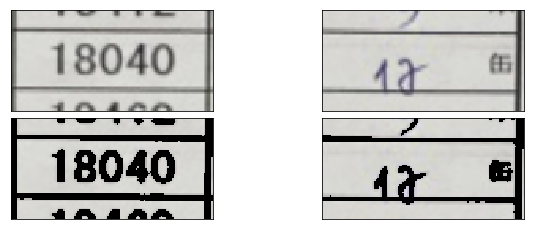

--predict left tesseract--
18040
--predict right tesseract--
ae 4]
--predict left--
[(0, 31. ) (1, 80.5) (2, 63.5) (3, 95. ) (4, 48. )]
[(0, 31. ) (4, 48. ) (2, 63.5) (1, 80.5) (3, 95. )]
[1, 8, 0, 4, 0]
--predict right--
[(0, 55.)]
[(0, 55.)]
[7]


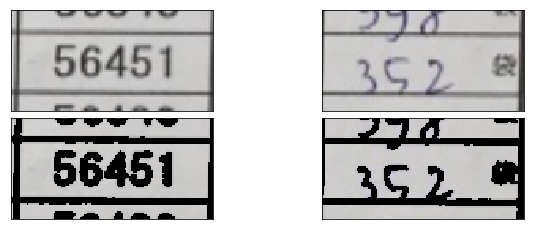

--predict left tesseract--
56451
--predict right tesseract--
e624
--predict left--
[(0, 66.) (1, 34.) (2, 82.)]
[(1, 34.) (0, 66.) (2, 82.)]
[5, 4, 5]
--predict right--
[(0, 74.5) (1, 73. ) (2, 29. ) (3, 47.5)]
[(2, 29. ) (3, 47.5) (1, 73. ) (0, 74.5)]
[7, 5, 7, 2]


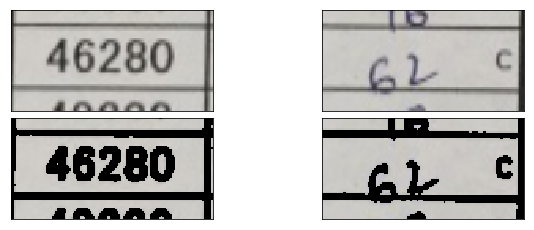

--predict left tesseract--
46280
--predict right tesseract--
ap a
--predict left--
[(0, 63.5) (1, 94.5) (2, 30.5) (3, 46.5) (4, 80. )]
[(2, 30.5) (3, 46.5) (0, 63.5) (4, 80. ) (1, 94.5)]
[4, 8, 2, 8, 0]
--predict right--
[(0, 38.5) (1, 55.5)]
[(0, 38.5) (1, 55.5)]
[2, 2]


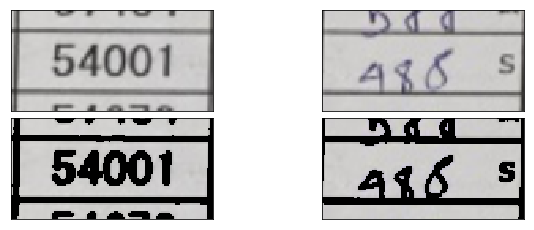

--predict left tesseract--
| 54001
--predict right tesseract--
Sagat
--predict left--
[(0, 81. ) (1, 99. ) (2, 34. ) (3, 65.5) (4, 52.5) (5, 33.5)]
[(5, 33.5) (2, 34. ) (4, 52.5) (3, 65.5) (0, 81. ) (1, 99. )]
[5, 2, 4, 0, 0, 1]
--predict right--
[(0, 31. ) (1, 51.5)]
[(0, 31. ) (1, 51.5)]
[2, 9]


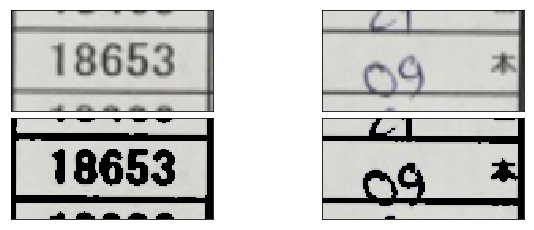

--predict left tesseract--
18653 |
--predict right tesseract--
rs
--predict left--
[(0, 88.5) (1, 47. ) (2, 47.5) (3, 72. )]
[(1, 47. ) (2, 47.5) (3, 72. ) (0, 88.5)]
[8, 0, 2, 2]
--predict right--
[(0, 56.5) (1, 37.5)]
[(1, 37.5) (0, 56.5)]
[0, 9]


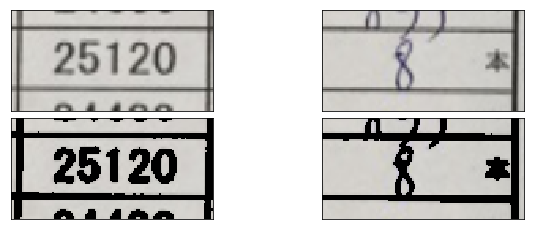

--predict left tesseract--
25120 |
--predict right tesseract--
a
--predict left--
[(0, 35.5) (1, 82.5) (2, 95.5)]
[(0, 35.5) (1, 82.5) (2, 95.5)]
[2, 2, 0]
--predict right--
[(0, 51.)]
[(0, 51.)]
[8]


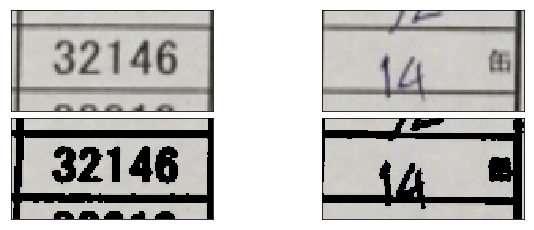

--predict left tesseract--
[32146 |
--predict right tesseract--
ta 4
--predict left--
[(0, 36.5) (1, 82.5) (2, 65. ) (3, 50.5) (4, 97.5)]
[(0, 36.5) (3, 50.5) (2, 65. ) (1, 82.5) (4, 97.5)]
[2, 2, 1, 4, 8]
--predict right--
[(0, 54.5)]
[(0, 54.5)]
[4]


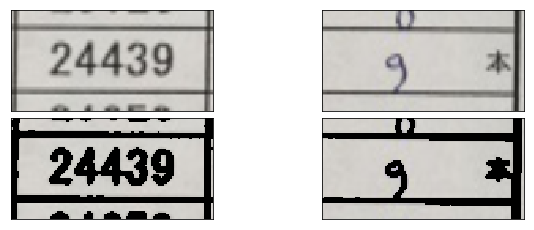

--predict left tesseract--
| 24439 |
--predict right tesseract--
3m
--predict left--
[(0, 32. ) (1, 55.5) (2, 76. ) (3, 71. )]
[(0, 32. ) (1, 55.5) (3, 71. ) (2, 76. )]
[2, 4, 4, 2]
--predict right--
[(0, 47.)]
[(0, 47.)]
[9]


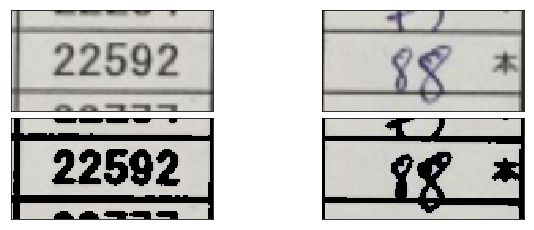

--predict left tesseract--
| 22592 |
--predict right tesseract--
9g 4
--predict left--
[(0, 34.5) (1, 49.5) (2, 99.5) (3, 66. ) (4, 81.5)]
[(0, 34.5) (1, 49.5) (3, 66. ) (4, 81.5) (2, 99.5)]
[2, 2, 2, 8, 2]
--predict right--
[(0, 70.) (1, 51.) (2, 72.) (3, 71.)]
[(1, 51.) (0, 70.) (3, 71.) (2, 72.)]
[8, 8, 4, 9]


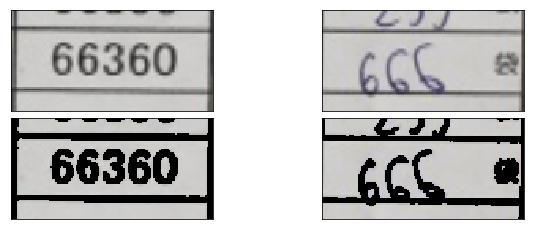

--predict left tesseract--
66360
--predict right tesseract--
“6cG
--predict left--
[(0, 97. ) (1, 82. ) (2, 49. ) (3, 61. ) (4, 33.5)]
[(4, 33.5) (2, 49. ) (3, 61. ) (1, 82. ) (0, 97. )]
[0, 2, 2, 0, 0]
--predict right--
[(0, 58.5) (1, 48. ) (2, 41.5)]
[(2, 41.5) (1, 48. ) (0, 58.5)]
[2, 7, 2]


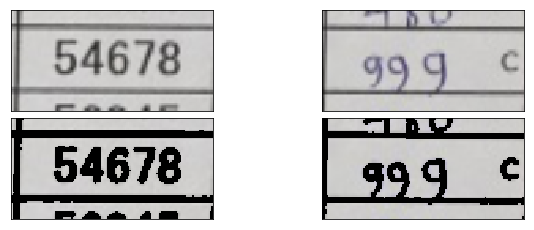

--predict left tesseract--
54678
--predict right tesseract--
Fagg <
--predict left--
[(0, 52. ) (1, 38. ) (2, 99. ) (3, 34.5)]
[(3, 34.5) (1, 38. ) (0, 52. ) (2, 99. )]
[5, 2, 4, 8]
--predict right--
[(0, 48. ) (1, 33. ) (2, 71.5)]
[(1, 33. ) (0, 48. ) (2, 71.5)]
[9, 9, 9]


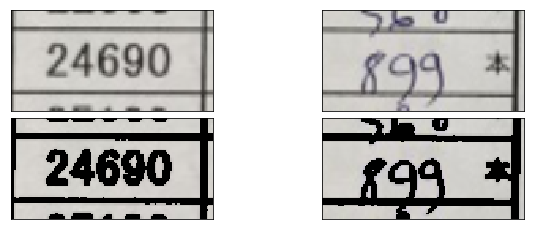

--predict left tesseract--
24690
--predict right tesseract--
~£98_4|
--predict left--
[(0, 93.5) (1, 30.5) (2, 45. ) (3, 62.5)]
[(1, 30.5) (2, 45. ) (3, 62.5) (0, 93.5)]
[2, 4, 0, 0]
--predict right--
[(0, 69.5) (1, 50.5) (2, 33.5)]
[(2, 33.5) (1, 50.5) (0, 69.5)]
[7, 9, 9]


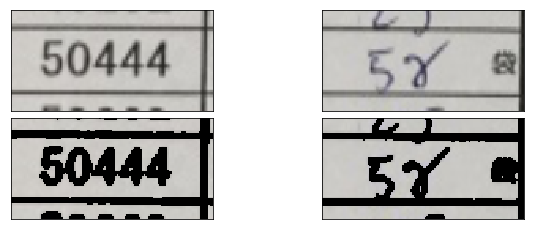

--predict left tesseract--
50444
--predict right tesseract--
5y 4
--predict left--
[(0, 91.5) (1, 75.5) (2, 59. ) (3, 29. )]
[(3, 29. ) (2, 59. ) (1, 75.5) (0, 91.5)]
[2, 4, 4, 4]
--predict right--
[(0, 37. ) (1, 60.5) (2, 68.5)]
[(0, 37. ) (1, 60.5) (2, 68.5)]
[5, 8, 1]


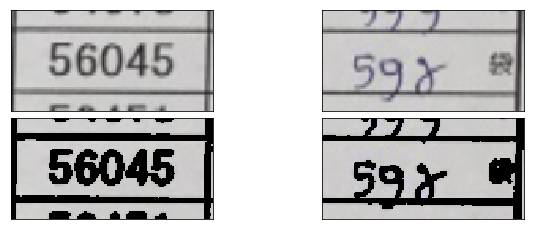

--predict left tesseract--
56045 |
--predict right tesseract--
“59x 4
--predict left--
[(0, 80. ) (1, 63.5) (2, 31.5) (3, 94. ) (4, 31.5)]
[(2, 31.5) (4, 31.5) (1, 63.5) (0, 80. ) (3, 94. )]
[5, 2, 0, 4, 2]
--predict right--
[(0, 43. ) (1, 34.5) (2, 70. )]
[(1, 34.5) (0, 43. ) (2, 70. )]
[2, 9, 4]


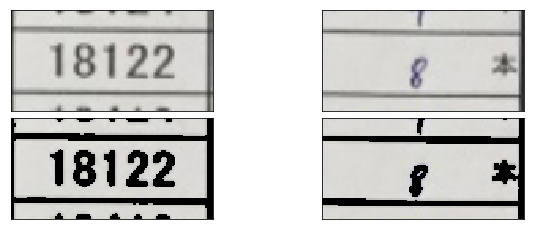

--predict left tesseract--
[18122 |
--predict right tesseract--
ew
--predict left--
[(0, 81.5) (1, 96. ) (2, 29. ) (3, 47. ) (4, 63.5)]
[(2, 29. ) (3, 47. ) (4, 63.5) (0, 81.5) (1, 96. )]
[1, 8, 1, 2, 2]
--predict right--
[(0, 61.5)]
[(0, 61.5)]
[9]


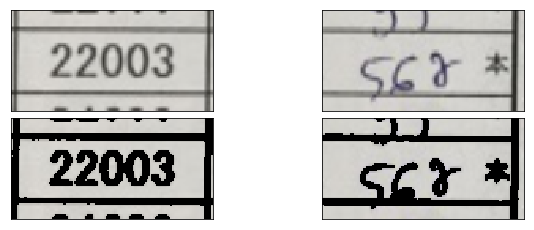

--predict left tesseract--
22003
--predict right tesseract--
ocr 4
--predict left--
[(0, 33. ) (1, 47.5) (2, 63.5) (3, 95.5) (4, 79.5)]
[(0, 33. ) (1, 47.5) (2, 63.5) (4, 79.5) (3, 95.5)]
[2, 2, 0, 0, 2]
--predict right--
[(0, 77.) (1, 49.) (2, 40.)]
[(2, 40.) (1, 49.) (0, 77.)]
[7, 2, 8]


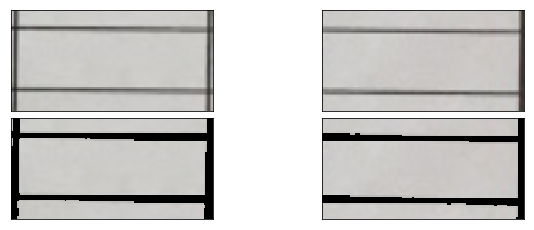

--predict left tesseract--
ae By
--predict right tesseract--
as
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


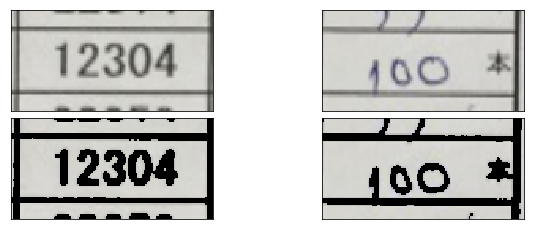

--predict left tesseract--
12304
--predict right tesseract--
100 4
--predict left--
[(0, 50.5) (1, 32.5) (2, 96. ) (3, 80.5) (4, 63.5) (5, 66.5)]
[(1, 32.5) (0, 50.5) (4, 63.5) (5, 66.5) (3, 80.5) (2, 96. )]
[1, 2, 2, 8, 0, 4]
--predict right--
[(0, 70.5) (1, 49.5)]
[(1, 49.5) (0, 70.5)]
[0, 0]


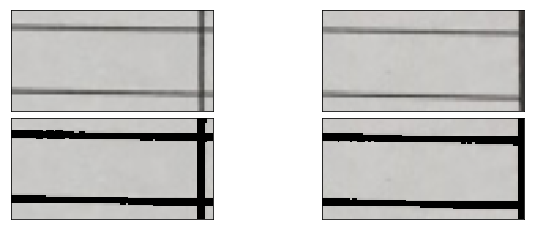

--predict left tesseract--
ioe
--predict right tesseract--
meal
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


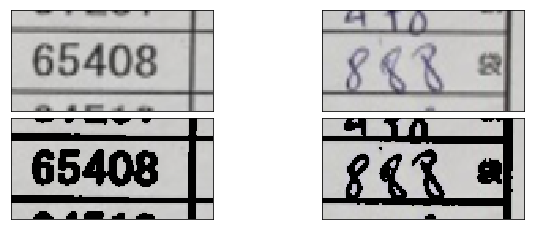

--predict left tesseract--
65408
--predict right tesseract--
£44 4
--predict left--
[(0, 54. ) (1, 84. ) (2, 37. ) (3, 20.5)]
[(3, 20.5) (2, 37. ) (0, 54. ) (1, 84. )]
[0, 2, 4, 8]
--predict right--
[(0, 22.)]
[(0, 22.)]
[8]


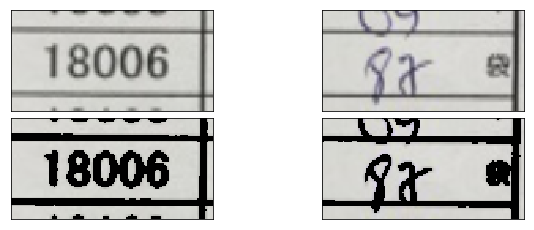

--predict left tesseract--
18006
--predict right tesseract--
“9x4
--predict left--
[(0, 60.5) (1, 45. ) (2, 77.5) (3, 26.5) (4, 91.5)]
[(3, 26.5) (1, 45. ) (0, 60.5) (2, 77.5) (4, 91.5)]
[1, 8, 0, 0, 0]
--predict right--
[(0, 57.5) (1, 51.5)]
[(1, 51.5) (0, 57.5)]
[4, 7]


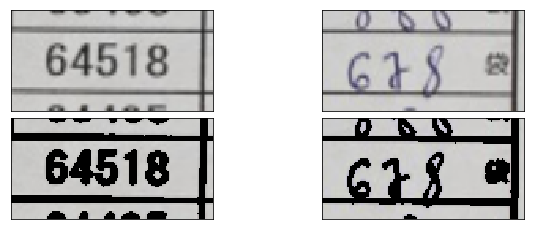

--predict left tesseract--
64518
--predict right tesseract--
“cts 4
--predict left--
[(0, 92.5) (1, 46. ) (2, 42. ) (3, 32. )]
[(3, 32. ) (2, 42. ) (1, 46. ) (0, 92.5)]
[2, 4, 2, 8]
--predict right--
[(0,  47. ) (1,  24. ) (2,  71.5) (3, 111.5)]
[(1,  24. ) (0,  47. ) (2,  71.5) (3, 111.5)]
[2, 7, 9, 9]


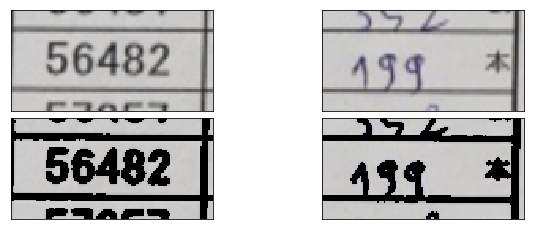

--predict left tesseract--
56482
--predict right tesseract--
A334]
--predict left--
[(0, 94. ) (1, 61.5) (2, 29.5) (3, 78. )]
[(2, 29.5) (1, 61.5) (3, 78. ) (0, 94. )]
[5, 4, 8, 2]
--predict right--
[(0, 58.5) (1, 41.5)]
[(1, 41.5) (0, 58.5)]
[9, 9]


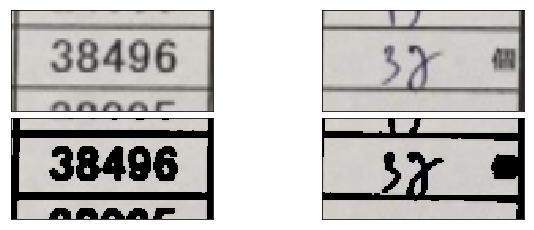

--predict left tesseract--
38496
--predict right tesseract--
Sa
--predict left--
[(0, 32.5) (1, 98. ) (2, 49. ) (3, 65.5) (4, 97.5)]
[(0, 32.5) (2, 49. ) (3, 65.5) (4, 97.5) (1, 98. )]
[2, 8, 4, 9, 8]
--predict right--
[(0, 65.5)]
[(0, 65.5)]
[7]


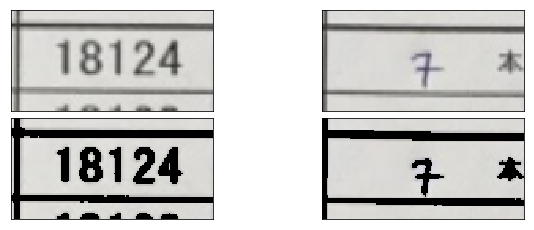

--predict left tesseract--
18124
--predict right tesseract--
a a
--predict left--
[(0,  85.5) (1, 100.5) (2,  51. ) (3,  33.5) (4,  51.5) (5,  67.5)]
[(3,  33.5) (2,  51. ) (4,  51.5) (5,  67.5) (0,  85.5) (1, 100.5)]
[1, 8, 0, 1, 2, 4]
--predict right--
[(0, 66.5)]
[(0, 66.5)]
[7]


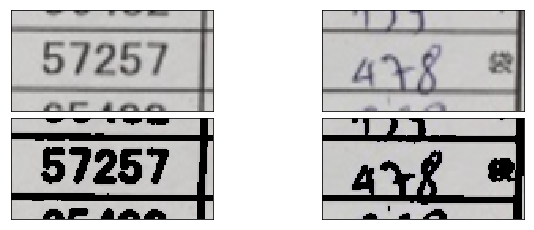

--predict left tesseract--
57257 |
--predict right tesseract--
“at _4|
--predict left--
[(0, 61. ) (1, 94. ) (2, 27.5) (3, 73.5)]
[(2, 27.5) (0, 61. ) (3, 73.5) (1, 94. )]
[5, 2, 2, 1]
--predict right--
[(0, 66.5) (1, 47.5)]
[(1, 47.5) (0, 66.5)]
[7, 8]


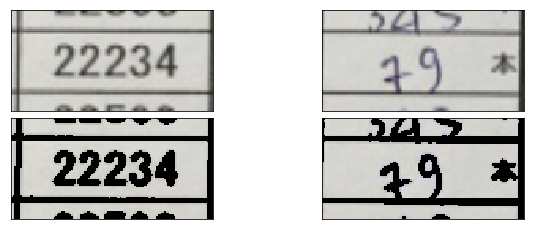

--predict left tesseract--
[ 22234 |
--predict right tesseract--
39 4
--predict left--
[(0, 35.5) (1, 66.5) (2, 49.5) (3, 97.5) (4, 80.5) (5, 82. )]
[(0, 35.5) (2, 49.5) (1, 66.5) (4, 80.5) (5, 82. ) (3, 97.5)]
[2, 2, 2, 2, 3, 4]
--predict right--
[(0, 68.5) (1, 46. ) (2, 57. )]
[(1, 46. ) (2, 57. ) (0, 68.5)]
[7, 4, 9]


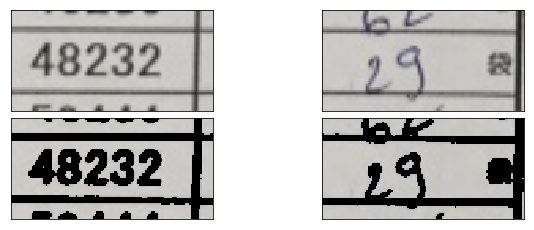

--predict left tesseract--
48232
--predict right tesseract--
194
--predict left--
[(0, 54.5) (1, 87.5) (2, 69.5) (3, 21.5) (4, 37.5) (5, 36. )]
[(3, 21.5) (5, 36. ) (4, 37.5) (0, 54.5) (2, 69.5) (1, 87.5)]
[4, 4, 8, 2, 2, 2]
--predict right--
[(0, 56.) (1, 34.)]
[(1, 34.) (0, 56.)]
[7, 9]


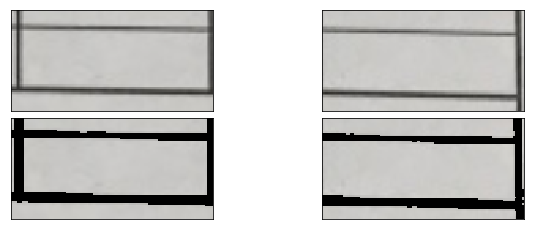

--predict left tesseract--
as
--predict right tesseract--
P|
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


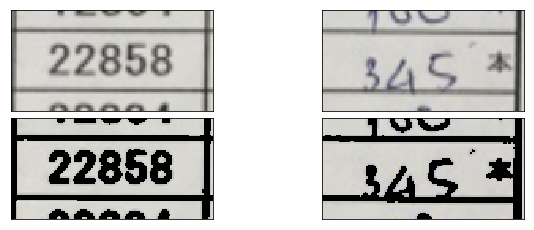

--predict left tesseract--
22858
--predict right tesseract--
sas 4
--predict left--
[(0, 32.5) (1, 46.5) (2, 95.5) (3, 63.5)]
[(0, 32.5) (1, 46.5) (3, 63.5) (2, 95.5)]
[2, 2, 8, 8]
--predict right--
[(0, 76.5)]
[(0, 76.5)]
[2]


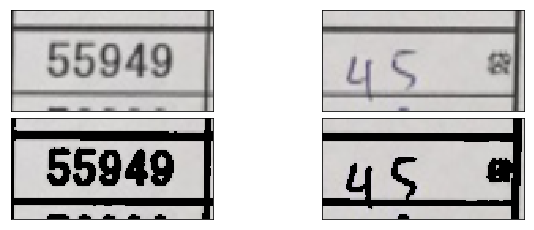

--predict left tesseract--
55949 |
--predict right tesseract--
ra
--predict left--
[(0, 79. ) (1, 93.5) (2, 31. ) (3, 31. )]
[(2, 31. ) (3, 31. ) (0, 79. ) (1, 93.5)]
[5, 2, 4, 0]
--predict right--
[(0, 24. ) (1, 52.5)]
[(0, 24. ) (1, 52.5)]
[4, 7]


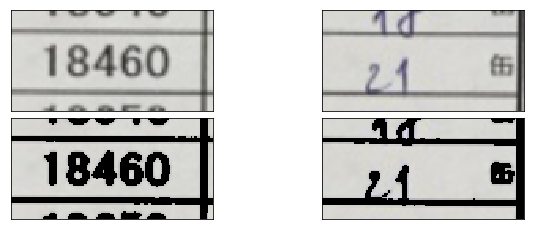

--predict left tesseract--
18460
--predict right tesseract--
SA 8
--predict left--
[(0, 93. ) (1, 25.5) (2, 43.5) (3, 58. ) (4, 77.5)]
[(1, 25.5) (2, 43.5) (3, 58. ) (4, 77.5) (0, 93. )]
[1, 8, 4, 0, 0]
--predict right--
[]
[]
[]


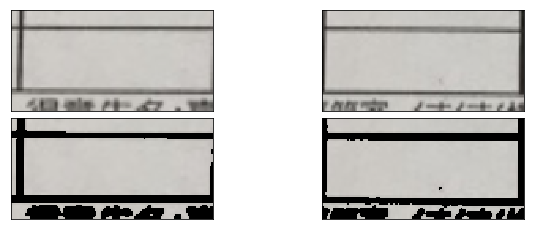

--predict left tesseract--
Reel
--predict right tesseract--
4
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


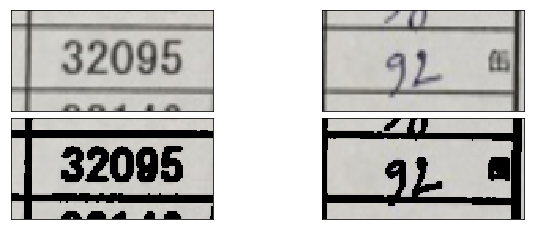

--predict left tesseract--
32095
--predict right tesseract--
[on al
--predict left--
[(0, 56.5) (1, 39.5)]
[(1, 39.5) (0, 56.5)]
[2, 2]
--predict right--
[(0, 47. ) (1, 66.5)]
[(0, 47. ) (1, 66.5)]
[9, 2]


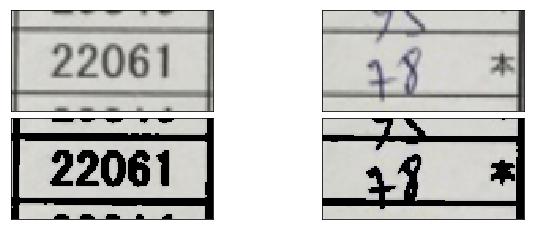

--predict left tesseract--
22061
--predict right tesseract--
4 om
--predict left--
[(0, 64.5) (1, 34. ) (2, 48. ) (3, 96. )]
[(1, 34. ) (2, 48. ) (0, 64.5) (3, 96. )]
[2, 2, 0, 1]
--predict right--
[(0,  56.) (1,  35.) (2, 114.) (3,  38.)]
[(1,  35.) (3,  38.) (0,  56.) (2, 114.)]
[9, 7, 9, 7]


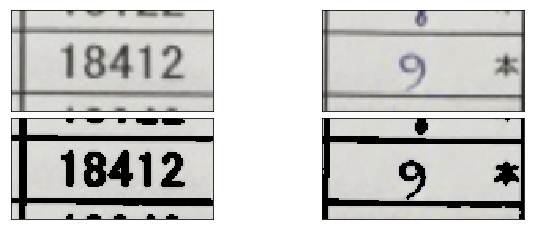

--predict left tesseract--
18412
--predict right tesseract--
ee
--predict left--
[(0, 102.5) (1,  36. ) (2,  54. ) (3,  65. ) (4,  86. )]
[(1,  36. ) (2,  54. ) (3,  65. ) (4,  86. ) (0, 102.5)]
[1, 8, 4, 1, 2]
--predict right--
[(0, 57.5)]
[(0, 57.5)]
[9]


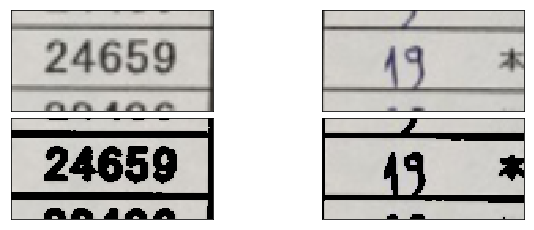

--predict left tesseract--
24659
--predict right tesseract--
ag 23
--predict left--
[(0, 29. ) (1, 46.5) (2, 64. )]
[(0, 29. ) (1, 46.5) (2, 64. )]
[2, 4, 8]
--predict right--
[(0, 58.5) (1, 43.5)]
[(1, 43.5) (0, 58.5)]
[4, 9]


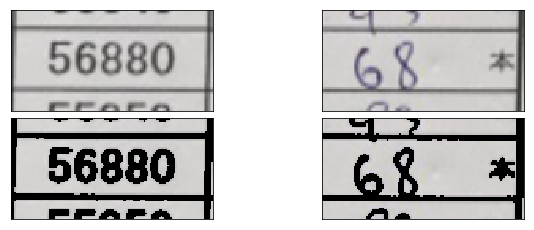

--predict left tesseract--
56880 |
--predict right tesseract--
“ok 4
--predict left--
[(0, 95.5) (1, 31.5) (2, 80. ) (3, 64.5) (4, 31.5) (5, 48.5)]
[(1, 31.5) (4, 31.5) (5, 48.5) (3, 64.5) (2, 80. ) (0, 95.5)]
[5, 2, 0, 8, 8, 0]
--predict right--
[(0, 52. ) (1, 29.5) (2, 30. )]
[(1, 29.5) (2, 30. ) (0, 52. )]
[6, 2, 8]


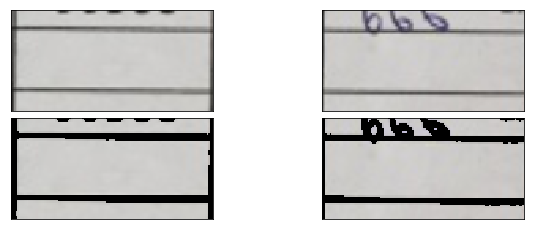

--predict left tesseract--
yoo a
--predict right tesseract--
ae
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


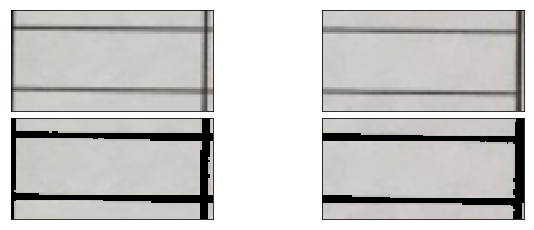

--predict left tesseract--
Eo
--predict right tesseract--
og
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


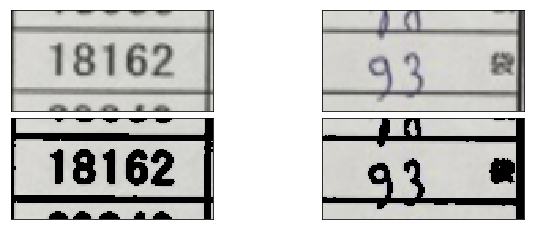

--predict left tesseract--
18162 |
--predict right tesseract--
334
--predict left--
[(0, 96.5) (1, 46.5) (2, 28.5) (3, 80.5) (4, 63.5)]
[(2, 28.5) (1, 46.5) (4, 63.5) (3, 80.5) (0, 96.5)]
[1, 8, 1, 0, 2]
--predict right--
[(0, 36.5) (1, 58.5)]
[(0, 36.5) (1, 58.5)]
[9, 9]


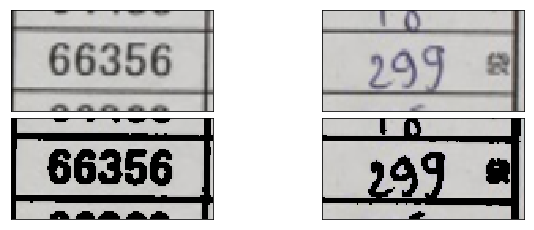

--predict left tesseract--
66356 |
--predict right tesseract--
209 |
--predict left--
[(0, 31. ) (1, 50. ) (2, 61. ) (3, 94.5) (4, 77.5)]
[(0, 31. ) (1, 50. ) (2, 61. ) (4, 77.5) (3, 94.5)]
[0, 2, 2, 2, 0]
--predict right--
[(0, 70.5) (1, 51. )]
[(1, 51. ) (0, 70.5)]
[9, 9]


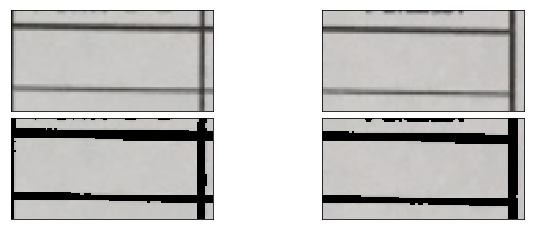

--predict left tesseract--
eee |
--predict right tesseract--
ae
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


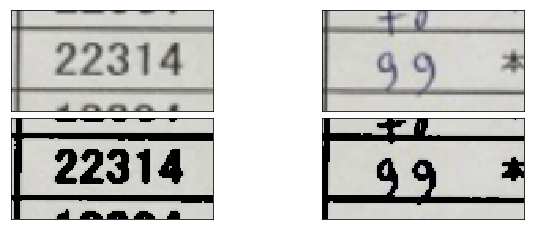

--predict left tesseract--
22314
--predict right tesseract--
39 *
--predict left--
[(0,  51.5) (1,  37.5) (2,  85.5) (3,  64.5) (4, 100. )]
[(1,  37.5) (0,  51.5) (3,  64.5) (2,  85.5) (4, 100. )]
[2, 2, 2, 1, 4]
--predict right--
[(0, 64.) (1, 41.)]
[(1, 41.) (0, 64.)]
[9, 9]


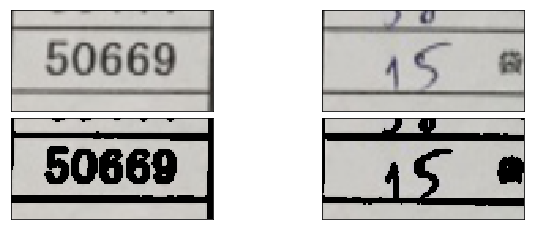

--predict left tesseract--
50668 |
--predict right tesseract--
ee
--predict left--
[(0, 30. ) (1, 45.5) (2, 96.5) (3, 81.5)]
[(0, 30. ) (1, 45.5) (3, 81.5) (2, 96.5)]
[2, 0, 0, 0]
--predict right--
[(0, 67.5) (1, 67. )]
[(1, 67. ) (0, 67.5)]
[2, 5]


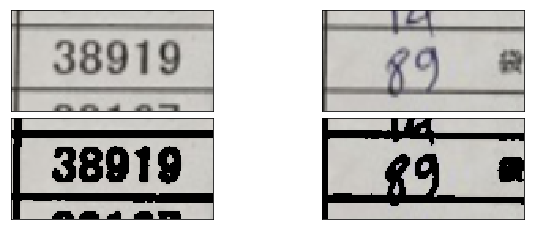

--predict left tesseract--
[38919
--predict right tesseract--
49 8
--predict left--
[(0, 99. ) (1, 56. ) (2, 33.5)]
[(2, 33.5) (1, 56. ) (0, 99. )]
[2, 8, 0]
--predict right--
[(0, 66.5) (1, 49. )]
[(1, 49. ) (0, 66.5)]
[9, 9]


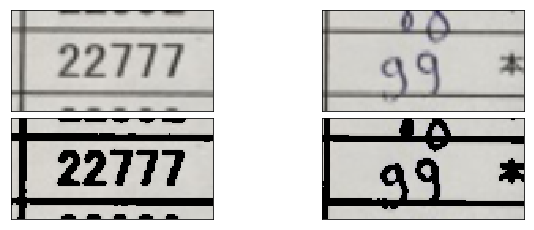

--predict left tesseract--
22777
--predict right tesseract--
aq
--predict left--
[(0,  38.5) (1,  51.5) (2, 103.5) (3,  87. ) (4,  69. )]
[(0,  38.5) (1,  51.5) (4,  69. ) (3,  87. ) (2, 103.5)]
[2, 2, 1, 1, 1]
--predict right--
[(0, 67.) (1, 45.)]
[(1, 45.) (0, 67.)]
[9, 9]


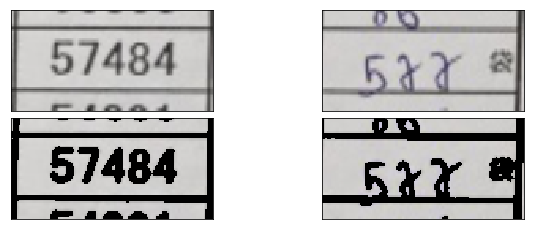

--predict left tesseract--
[57484 |
--predict right tesseract--
“52a 4
--predict left--
[(0, 64. ) (1, 96.5) (2, 81. ) (3, 38.5) (4, 34. )]
[(4, 34. ) (3, 38.5) (0, 64. ) (2, 81. ) (1, 96.5)]
[5, 2, 4, 8, 4]
--predict right--
[(0, 79.) (1, 53.) (2, 34.)]
[(2, 34.) (1, 53.) (0, 79.)]
[5, 7, 7]


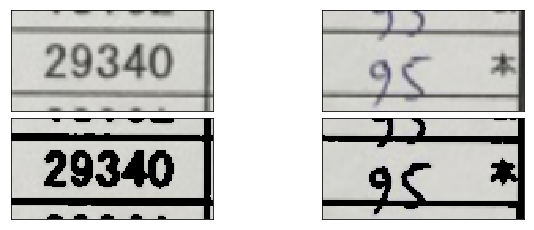

--predict left tesseract--
29340
--predict right tesseract--
ae
--predict left--
[(0, 94.5) (1, 28. ) (2, 79. ) (3, 44.5) (4, 62.5)]
[(1, 28. ) (3, 44.5) (4, 62.5) (2, 79. ) (0, 94.5)]
[2, 2, 2, 4, 0]
--predict right--
[(0, 37. ) (1, 60.5) (2, 48.5)]
[(0, 37. ) (2, 48.5) (1, 60.5)]
[9, 2, 7]


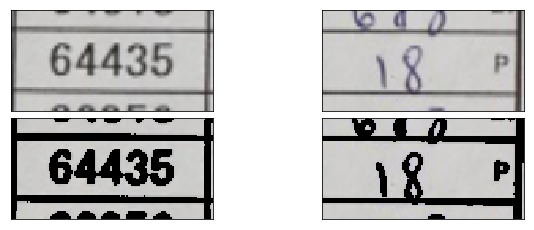

--predict left tesseract--
64435
--predict right tesseract--
“18 I
--predict left--
[(0, 60.5) (1, 49. ) (2, 78.5) (3, 33. ) (4, 72.5) (5, 95. )]
[(3, 33. ) (1, 49. ) (0, 60.5) (4, 72.5) (2, 78.5) (5, 95. )]
[8, 4, 4, 4, 2, 5]
--predict right--
[(0,  56.5) (1,  37.5) (2, 114. )]
[(1,  37.5) (0,  56.5) (2, 114. )]
[1, 8, 9]


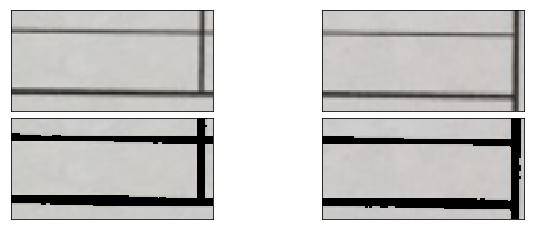

--predict left tesseract--
a ea
--predict right tesseract--
o
--predict left--
[]
[]
[]
--predict right--
[]
[]
[]


[('', '252523', '82'),
 ('', '', ''),
 ('18040', '18040', '7'),
 ('56451', '545', '7572'),
 ('46280', '48280', '22'),
 ('54001', '524001', '29'),
 ('18653', '8022', '09'),
 ('25120', '220', '8'),
 ('32146', '22148', '4'),
 ('24439', '2442', '9'),
 ('22592', '22282', '8849'),
 ('66360', '02200', '272'),
 ('54678', '5248', '999'),
 ('24690', '2400', '799'),
 ('50444', '2444', '581'),
 ('56045', '52042', '294'),
 ('18122', '18122', '9'),
 ('22003', '22002', '728'),
 ('', '', ''),
 ('12304', '122804', '00'),
 ('', '', ''),
 ('65408', '0248', '8'),
 ('18006', '18000', '47'),
 ('64518', '2428', '2799'),
 ('56482', '5482', '99'),
 ('38496', '28498', '7'),
 ('18124', '180124', '7'),
 ('57257', '5221', '78'),
 ('22234', '222234', '749'),
 ('48232', '448222', '79'),
 ('', '', ''),
 ('22858', '2288', '2'),
 ('55949', '5240', '47'),
 ('18460', '18400', ''),
 ('', '', ''),
 ('32095', '22', '92'),
 ('22061', '2201', '9797'),
 ('18412', '18412', '9'),
 ('24659', '248', '49'),
 ('56880', '520880', '62

In [158]:
results = predict_all(crops)
results

In [159]:
def rextract(res):
    (a, b, c) = res
    return [a, c]
res = list(map(rextract, results))

In [160]:
len(res)

53

In [161]:
res

[['', '82'],
 ['', ''],
 ['18040', '7'],
 ['56451', '7572'],
 ['46280', '22'],
 ['54001', '29'],
 ['18653', '09'],
 ['25120', '8'],
 ['32146', '4'],
 ['24439', '9'],
 ['22592', '8849'],
 ['66360', '272'],
 ['54678', '999'],
 ['24690', '799'],
 ['50444', '581'],
 ['56045', '294'],
 ['18122', '9'],
 ['22003', '728'],
 ['', ''],
 ['12304', '00'],
 ['', ''],
 ['65408', '8'],
 ['18006', '47'],
 ['64518', '2799'],
 ['56482', '99'],
 ['38496', '7'],
 ['18124', '7'],
 ['57257', '78'],
 ['22234', '749'],
 ['48232', '79'],
 ['', ''],
 ['22858', '2'],
 ['55949', '47'],
 ['18460', ''],
 ['', ''],
 ['32095', '92'],
 ['22061', '9797'],
 ['18412', '9'],
 ['24659', '49'],
 ['56880', '628'],
 ['', ''],
 ['', ''],
 ['18162', '99'],
 ['66356', '99'],
 ['', ''],
 ['22314', '99'],
 ['50668', '25'],
 ['38919', '99'],
 ['22777', '99'],
 ['57484', '577'],
 ['29340', '927'],
 ['64435', '189'],
 ['', '']]

In [162]:
import pandas as pd

In [163]:
df = pd.read_csv('dataset_csv/imageresized_40.csv',header=None)
df.columns = [
  'product',
  'order'
]

In [164]:
df

product  order
0     18124      7
1     18122      8
2     18412      9
3     18040     17
4     18460     21
5     18653      9
6     18006     87
7     18162     93
8     29340     95
9     22061     78
10    22314     99
11    12304    100
12    22858    345
13    22234     79
14    22592     88
15    22777     99
16    22003    567
17    24690    899
18    25120      8
19    24439      9
20    24659     19
21    38496     37
22    32095     92
23    32146     14
24    38919     89
25    38167     16
26    46280     62
27    48232     29
28    50444     57
29    50669     15
30    55949     45
31    56880     68
32    55853     86
33    57484    577
34    54001    485
35    54678    999
36    56045    597
37    56451    352
38    56482    199
39    57257    478
40    65408    888
41    64518    678
42    64435     18
43    66356    299
44    66360    666

In [165]:
df1 = pd.DataFrame(res, columns=['product', 'order'])

In [166]:
df1

product order
0             82
1               
2    18040     7
3    56451  7572
4    46280    22
5    54001    29
6    18653    09
7    25120     8
8    32146     4
9    24439     9
10   22592  8849
11   66360   272
12   54678   999
13   24690   799
14   50444   581
15   56045   294
16   18122     9
17   22003   728
18              
19   12304    00
20              
21   65408     8
22   18006    47
23   64518  2799
24   56482    99
25   38496     7
26   18124     7
27   57257    78
28   22234   749
29   48232    79
30              
31   22858     2
32   55949    47
33   18460      
34              
35   32095    92
36   22061  9797
37   18412     9
38   24659    49
39   56880   628
40              
41              
42   18162    99
43   66356    99
44              
45   22314    99
46   50668    25
47   38919    99
48   22777    99
49   57484   577
50   29340   927
51   64435   189
52

In [167]:
# df1.loc[df1['product'] == 55853]
row_count = 0
value_count = 0
for index, row in df.iterrows():
#     print(row['product'])
#     print(str(row['product']))
#     if df1['product'] == str(row['product']):
#         print(row.product)
    f = df1.loc[df1['product'] == str(row['product'])]
    if len(f.values) > 0:
        if True:
            print("(index, GT, predicted) :", index, ',', row['order'], ',', f['order'].iloc[0])
        if str(f['order'].iloc[0]) == str(row['order']):
            value_count = value_count +1
        
        row_count = row_count+1
        
print("predicted row count:", row_count)
print("predicted row percent:", row_count/len(df.index))
print("predicted value count:", value_count)
print("predicted value percent:", value_count/len(df.index))


# for index, row in df1.iterrows():
#    print(row.values)

(index, GT, predicted) : 0 , 7 , 7
(index, GT, predicted) : 1 , 8 , 9
(index, GT, predicted) : 2 , 9 , 9
(index, GT, predicted) : 3 , 17 , 7
(index, GT, predicted) : 4 , 21 , 
(index, GT, predicted) : 5 , 9 , 09
(index, GT, predicted) : 6 , 87 , 47
(index, GT, predicted) : 7 , 93 , 99
(index, GT, predicted) : 8 , 95 , 927
(index, GT, predicted) : 9 , 78 , 9797
(index, GT, predicted) : 10 , 99 , 99
(index, GT, predicted) : 11 , 100 , 00
(index, GT, predicted) : 12 , 345 , 2
(index, GT, predicted) : 13 , 79 , 749
(index, GT, predicted) : 14 , 88 , 8849
(index, GT, predicted) : 15 , 99 , 99
(index, GT, predicted) : 16 , 567 , 728
(index, GT, predicted) : 17 , 899 , 799
(index, GT, predicted) : 18 , 8 , 8
(index, GT, predicted) : 19 , 9 , 9
(index, GT, predicted) : 20 , 19 , 49
(index, GT, predicted) : 21 , 37 , 7
(index, GT, predicted) : 22 , 92 , 92
(index, GT, predicted) : 23 , 14 , 4
(index, GT, predicted) : 24 , 89 , 99
(index, GT, predicted) : 26 , 62 , 22
(index, GT, predicted) : 27